In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, \
    precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the preprocessed data

In [3]:
DATA_PATH = './preprocessed_data'
CHAR_PATH = os.path.join(DATA_PATH, 'characters_preprocessed.tsv')
SCORE_FUNCTION_PATH = os.path.join(DATA_PATH, 'score_function.tsv')

### 1.1 Characters dataset

In [4]:
df_chars = pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date'] = pd.to_datetime(df_chars['m_release_date'], errors='coerce')
df_chars['actor_dob'] = pd.to_datetime(df_chars['actor_dob'], errors='coerce')
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,min_year_score
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,NaN
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,2000.0,57.0


### 1.2 The score function

In [5]:
df_numbers = pd.read_csv(SCORE_FUNCTION_PATH, sep='\t')
df_numbers.set_index('actor_name', inplace=True)
df_numbers.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,99.0,346.5,181.5,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,137.400000,...,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250,1980,99.0
Clint Eastwood,348.0,174.0,460.0,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,1454.709524,...,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952,1980,348.0


# 2. Dataset preparation

#### Add a new column: 
* `min_year_starring`: it corresponds to the starting year of career of an actor

In [6]:
map_min_year_starring = df_chars.groupby(['actor_name'])['m_release_year'].min()
df_chars['min_year_starring'] = df_chars['actor_name'].map(lambda x: map_min_year_starring[x])

#### Add two new columns:
* `is_revealed`: boolean which is true if the release year of the movie the actor is starring in correspond to the year the actor has appeared in the numbers' ranking for the first time
* `already_revealed`: boolean which is true if the release year of the movie the actor is starring in correspond to a greater year than your revelation year: the actor has already appeared in the numbers ranking before starring in this movie

In [7]:
df_chars['is_revealed'] = df_chars.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars['already_revealed'] = df_chars.apply(
    lambda row: row['min_year'] < row['m_release_date'].year and row['min_year'] != 0.0, axis=1).astype(int)

#### Add a new column:
* `popularity`: Categorical column which takes three possible values: **famous**, **revelation**, **unknown**. It corresponds to, at the release year of the movie, either: have been already revealed in the numbers at that time, being revealed at that time, or haven't been revealed at that time.

In [8]:
def get_popularity(row):
    if (row.is_revealed == 0) and (row.already_revealed == 0):
        return 'unknown'
    if (row.is_revealed == 0) and (row.already_revealed == 1):
        return 'famous'
    if (row.is_revealed == 1) and (row.already_revealed == 0):
        return 'revelation'
    if (row.is_revealed == 1) and (row.already_revealed == 1):
        raise ValueError('The actor {} has a value 1 for is_revealed and 1 for already_revealed'.format(row.actor_name))

In [9]:
df_chars['popularity'] = df_chars.apply(lambda row: get_popularity(row), axis=1)

# 3. Insight on coacting effect

# 4. Regression analysis: how co-acting impacts being revealed

## 4.1 Features of actor score

In [10]:
df_regression = df_chars.copy()

#### Column conversion
* add a column `actor_gender_cat`: it represents the actor gender as a binary input

In [11]:
df_regression['actor_gender_cat'] = (df_regression['actor_gender'] == 'F').astype(int)

#### Drop columns 
* Two columns won't be used for the analysis: `actor_height` and `actor_ethnicity`

In [12]:
df_regression.drop(['actor_height', 'actor_ethnicity', 'm_release_date'], axis=1, inplace=True)

#### Number of actors per movie
* add a new column: `nb_actors`: Number of actors per movie

In [13]:
#compute number of actors per movie
map_nb_actors_per_movie = df_regression.groupby(['wikipedia_m_ID'])['actor_name'].count()
df_regression['nb_actors'] = df_regression['wikipedia_m_ID'].map(lambda x: map_nb_actors_per_movie[x])

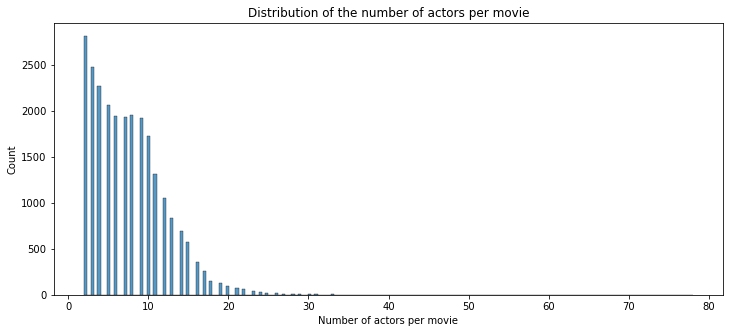

In average, there are 7.61 actors per movie in our dataset.
It corresponds to 24884 different movies.


In [14]:
#nb actors per movie
plt.figure(figsize=(12, 5))
sns.histplot(data=df_regression.drop_duplicates('wikipedia_m_ID'), x='nb_actors')
plt.title("Distribution of the number of actors per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors per movie")
plt.show()
avg_nb_actors_per_movie = df_regression.drop_duplicates('wikipedia_m_ID')['nb_actors'].mean()
nb_unique_movies_with_actors = df_regression['wikipedia_m_ID'].nunique()
print("In average, there are {:.2f} actors per movie in our dataset.".format(avg_nb_actors_per_movie))
print("It corresponds to {} different movies.".format(nb_unique_movies_with_actors))

#### Number of movies of each actor before releasing movie
* add a new column `nb_movies_before_releasing_movie`: it corresponds to the number of movies an actor has starred in before playing in the movie row

In [15]:
map_nb_movies_per_year = df_regression.groupby(['actor_name', 'm_release_year'])['wikipedia_m_ID'].count().reset_index()

In [16]:
year = range(1980, 2013)
list_nb_movies_at_year = dict()
for y in year:
    filter_conditions = (
        (map_nb_movies_per_year['m_release_year'] < y)
    )
    list_nb_movies = map_nb_movies_per_year.loc[filter_conditions]
    list_nb_movies = list_nb_movies.groupby('actor_name')['wikipedia_m_ID'].sum()
    list_nb_movies_at_year.update({y: list_nb_movies})

In [19]:
def get_nb_movies_each_year(row):
    release_year = row['m_release_year']
    actor_name = row['actor_name']
    try:
        df_tmp = list_nb_movies_at_year[release_year]
        nb_movies = df_tmp[actor_name]
        return nb_movies
    except:
        return 0

In [20]:
df_regression['nb_movies_before_this_movie'] = df_regression.apply(lambda row: get_nb_movies_each_year(row), axis=1)

#### Number of movies per decade
* Add four columns that compute the number of movies an actor has performed during each decade

In [21]:
nb_decades_lower = range(1980, 2030, 10)
nb_decades_upper = range(1990, 2030, 10)
list_decades = dict()
for dec_lower, dec_upper in zip(nb_decades_lower, nb_decades_upper):
    filter_conditions = (
            (map_nb_movies_per_year['m_release_year'] >= dec_lower) &
            (map_nb_movies_per_year['m_release_year'] < dec_upper)
    )
    list_dec = map_nb_movies_per_year.loc[filter_conditions]
    list_dec = list_dec.groupby('actor_name')['wikipedia_m_ID'].count().reset_index()
    list_dec['wikipedia_m_ID'] = list_dec['wikipedia_m_ID'].astype(int)
    list_dec.rename({'wikipedia_m_ID': 'nb_movies_dec_{}_{}'.format(dec_lower, dec_upper)}, axis=1, inplace=True)
    list_decades.update({range(dec_lower, dec_upper): list_dec})

In [22]:
for key, dec in list_decades.items():
    df_regression = df_regression.merge(dec, on='actor_name', how='left')
    df_regression['nb_movies_dec_{}_{}'.format(key.start, key.stop)].fillna(0, inplace=True)

In [23]:
df_regression.head(2)

,wikipedia_m_ID,character_name,actor_dob,actor_gender,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,...,is_revealed,already_revealed,popularity,actor_gender_cat,nb_actors,nb_movies_before_this_movie,nb_movies_dec_1980_1990,nb_movies_dec_1990_2000,nb_movies_dec_2000_2010,nb_movies_dec_2010_2020
0,975900,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,0,0,unknown,1,13,3,0.0,2.0,4.0,0.0
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,Natasha Henstridge,27.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,2000.0,...,0,1,famous,1,13,8,0.0,3.0,6.0,0.0


#### Retrieve the scores per actor at movie time
* add a new column `actor_score`: it corresponds to the score of the actor at the year before starring the movie

In [31]:
def retrieve_actor_score(row):
    score_year_to_retrieve = row['m_release_year'] - 1
    actor_name = row['actor_name']
    try:
        return df_numbers['{}'.format(score_year_to_retrieve)][actor_name]
    except:
        return 0

In [32]:
df_regression['actor_score'] = df_regression.apply(lambda row: retrieve_actor_score(row), axis=1)

#### Keep only movies strictly after 1980 (minimal year for which we have an actor score)

In [33]:
# Keep only movies after 1980
df_regression = df_regression[df_regression['m_release_year'] > 1980].copy()

#### Quick analysis just for fun

In [34]:
nb_unique_movies = df_regression['wikipedia_m_ID'].nunique()
print("There are {} unique movies released after 1980 and with at least two actors in the dataset.".format(
    nb_unique_movies))

There are 13712 unique movies released after 1980 and with at least two actors in the dataset.


In [35]:
nb_actors = df_regression['actor_name'].nunique()
nb_actors_who_started_carreer_after_1980 = df_regression.loc[(df_regression['nb_movies_before_this_movie'] == 0)][
    'actor_name'].nunique()
print("There are {} actors in this dataset.".format(nb_actors))
print("Among them, there are {} actors who had started their carreer before 1980.".format(
    nb_actors - nb_actors_who_started_carreer_after_1980))

There are 24701 actors in this dataset.
Among them, there are 3732 actors who had started their carreer before 1980.


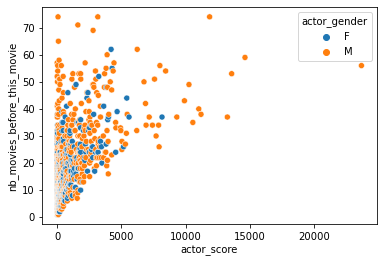

In [36]:
sns.scatterplot(
    data=df_regression.loc[(df_regression['actor_score'] > 0)].sort_values('actor_score').drop_duplicates('actor_name',
                                                                                                          keep='last'),
    y='nb_movies_before_this_movie', x='actor_score', hue="actor_gender");

In [37]:
women_nb_movies_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'F')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']
men_nb_movies_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'M')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']

In [38]:
women_mean_nb_movies_highest_score = women_nb_movies_highest_score.mean()
men_mean_nb_movies_highest_score = men_nb_movies_highest_score.mean()
print("At the peak of their carreer, women had before performed {:.2f} movies in average.".format(
    women_mean_nb_movies_highest_score))
print("At the peak of their carreer, men had before performed {:.2f} movies in average.".format(
    men_mean_nb_movies_highest_score))
ttest_ind(women_nb_movies_highest_score, men_nb_movies_highest_score)

At the peak of their carreer, women had before performed 12.32 movies in average.
At the peak of their carreer, men had before performed 16.21 movies in average.


Ttest_indResult(statistic=-5.362465244255523, pvalue=9.619260122200605e-08)

In [39]:
women_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'F')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['actor_score']
men_highest_score = \
    df_regression.loc[(df_regression['actor_score'] > 0) & (df_regression['actor_gender'] == 'M')].sort_values(
        'actor_score').drop_duplicates('actor_name', keep='last')['actor_score']

In [40]:
women_mean_highest_score = women_highest_score.mean()
men_mean_highest_score = men_highest_score.mean()
print("At the peak of their carreer, women have in average reached a score of {:.2f}.".format(women_mean_highest_score))
print("At the peak of their carreer, men have in average reached a score of {:.2f}.".format(men_mean_highest_score))
ttest_ind(women_highest_score, men_highest_score)

At the peak of their carreer, women have in average reached a score of 525.89.
At the peak of their carreer, men have in average reached a score of 890.59.


Ttest_indResult(statistic=-4.022467941449092, pvalue=6.0723689662790975e-05)

## 3.2 Compute movie features

In [41]:
columns = ['wikipedia_m_ID', 'actor_name', 'actor_gender', 'actor_score']
df_temp = df_regression.copy()
df_temp['actor_score'] = df_temp['actor_score'].astype(str)
df_temp['actor_gender'] = df_temp['actor_gender'].astype(str)
df_movies_features = df_temp[columns].groupby('wikipedia_m_ID').agg(
    {'actor_name': '$l$'.join, 'actor_gender': '$l$'.join, 'actor_score': '$l$'.join})

In [42]:
df_movies_features

,actor_name,actor_gender,actor_score
wikipedia_m_ID,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M,0.0$l$250.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0....
3947,Isabella Rossellini$l$Kyle MacLachlan$l$Dennis...,F$l$M$l$M$l$F$l$F$l$M$l$M$l$F$l$F$l$M$l$M,0.0$l$34.5$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0...
4231,Kristy Swanson$l$Donald Sutherland$l$Paul Reub...,F$l$M$l$M$l$M$l$M$l$F$l$M$l$M$l$M$l$M$l$F$l$F$...,0.0$l$0.0$l$11.571428571428571$l$15.7142857142...
4560,Tommy Flanagan$l$Sean Lawlor$l$Sophie Marceau$...,M$l$M$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$...,0.0$l$0.0$l$0.0$l$0.0$l$2844.061904761905$l$0....
...,...,...,...
36619262,Leonardo Nam$l$Gillian Jacobs$l$Peter Scanavino,M$l$F$l$M,0.0$l$0.0$l$0.0
36724042,John Barrowman$l$Ryan Cutrona$l$Bashar Rahal,M$l$M$l$M,0.0$l$0.0$l$0.0
36956792,Bruce Allpress$l$Ben Chaplin$l$Brian Cox$l$Ale...,M$l$M$l$M$l$M$l$M$l$M$l$M$l$M$l$F$l$F,0.0$l$4.666666666666667$l$0.0$l$0.0$l$0.0$l$0....


In [43]:
def get_function_of_list_values_condition(row, function, gender_bool=None):
    list_temp = row['actor_score'].split('$l$')
    gender_split = row['actor_gender'].split('$l$')
    list_temp = [float(x) for x in list_temp]
    if gender_bool:
        list_split = []
        for x, gender in zip(list_temp, gender_split):
            if gender == gender_bool:
                list_split.append(x)
    else:
        list_split = list_temp
    if len(list_split) == 0:
        return np.nan
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(list_split)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        if gender_bool:
            try:
                return (np.count_nonzero(list_split)) / np.count_nonzero(list_temp)
            except:
                return 0
        else:
            return (np.count_nonzero(list_split)) / float(len(list_split))

In [44]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_movies_features['cast_' + f] = df_movies_features.apply(
        lambda row: get_function_of_list_values_condition(row, f), axis=1)

In [45]:
list_function_score = ['max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
gender_list = ['M', 'F']
for gender in gender_list:
    for f in list_function_score:
        df_movies_features[gender + '_' + f] = df_movies_features.apply(
            lambda row: get_function_of_list_values_condition(row, f, gender_bool=gender), axis=1)


In [46]:
df_movies_features.head(2)

,actor_name,actor_gender,actor_score,cast_max,cast_min,cast_mean,cast_median,cast_nb_famous_actors,cast_prop_famous_actors,M_max,...,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,F_max,F_min,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors
wikipedia_m_ID,,,,,,,,,,,,,,,,,,,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...,0.0,0.0,0.000000,0.0,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,M$l$M$l$M$l$F$l$F$l$F$l$M$l$M$l$M$l$M$l$M$l$M$l$M,0.0$l$250.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0....,250.0,0.0,19.230769,0.0,1,0.076923,250.0,...,25.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.3 Compute actor story

In [47]:
list_columns = ['cast_' + x for x in list_function_score] + ['F_' + x for x in list_function_score] + ['M_' + x for x in
                                                                                                       list_function_score]

In [48]:
df_regression_merged = df_regression.merge(df_movies_features[list_columns], left_on='wikipedia_m_ID', right_index=True,
                                           how='left').copy()
df_regression_merged.head(3)

,wikipedia_m_ID,character_name,actor_dob,actor_gender,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,...,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors
0,975900,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,Natasha Henstridge,27.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,2000.0,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333
2,975900,Desolation Williams,1969-06-15,M,Ice Cube,32.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,1991.0,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333


#### Filter out actors when movie released date was after his·her revelation

In [50]:
filter_conditions = (
    (df_regression_merged['already_revealed'] == 0)

)
df_regression_filtered = df_regression_merged.loc[filter_conditions]
df_regression_filtered.head(2)

,wikipedia_m_ID,character_name,actor_dob,actor_gender,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,...,F_mean,F_median,F_nb_famous_actors,F_prop_famous_actors,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors
0,975900,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333
7,975900,Michael Descanso,1971-03-20,M,Liam Waite,30.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,37.561111,10.85,4.0,0.666667,1458.8,0.0,213.828571,0.0,2.0,0.333333


#### Mapping past of actor

In [52]:
aggregation = {"cast_max": "max", "cast_mean": "mean", "cast_prop_famous_actors": "mean",
               "cast_prop_famous_actors": "max", "cast_nb_famous_actors": "max"}
map_past_of_actor = df_regression_filtered.groupby(['actor_name', 'm_release_year']).agg(aggregation).reset_index()

In [53]:
year = range(1982, 2013)
#columns = ["score_max", "score_mean", "score_prop_famous_actors", "score_prop_famous_actors", "score_nb_famous_actors"]
list_past_actors_per_year = pd.DataFrame()
for y in year:
    filter_conditions = (
            (map_past_of_actor['m_release_year'] >= y - 3) &
            (map_past_of_actor['m_release_year'] <= y)
    )
    list_past_actors = map_past_of_actor.loc[filter_conditions].copy()
    list_past_actors = list_past_actors.groupby('actor_name').agg(aggregation)
    previous_col = list_past_actors.columns
    list_past_actors.columns = ['previous_' + c for c in previous_col]
    list_past_actors['m_release_year'] = list_past_actors.apply(lambda row: y, axis=1)
    list_past_actors_per_year = pd.concat([list_past_actors_per_year, list_past_actors])

list_past_actors_per_year.reset_index(inplace=True)

In [54]:
df_final = df_regression_filtered.merge(list_past_actors_per_year, on=['actor_name', 'm_release_year'], how='left')
df_final.head()

,wikipedia_m_ID,character_name,actor_dob,actor_gender,actor_name,actor_age,m_name,m_genre_PCA,m_release_year,min_year,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,previous_cast_max,previous_cast_mean,previous_cast_prop_famous_actors,previous_cast_nb_famous_actors
0,975900,Akooshay,1958-08-26,F,Wanda De Jesus,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,1458.8,0.0,213.828571,0.0,2.0,0.333333,1458.800000,66.237179,0.461538,6.0
1,975900,Michael Descanso,1971-03-20,M,Liam Waite,30.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,1458.8,0.0,213.828571,0.0,2.0,0.333333,2425.821429,295.279175,0.461538,6.0
2,975900,Tres,1959-03-09,M,Rodney A. Grant,42.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,1458.8,0.0,213.828571,0.0,2.0,0.333333,3241.953846,120.166090,0.461538,6.0
3,975900,McSimms,1944-07-22,M,Peter Jason,57.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,1458.8,0.0,213.828571,0.0,2.0,0.333333,1458.800000,67.542735,0.500000,6.0
4,975900,Benchley,1935-08-13,M,Doug McGrath,66.0,Ghosts of Mars,"Thriller, Crime Thriller, Action, Mystery",2001,NaN,...,1458.8,0.0,213.828571,0.0,2.0,0.333333,1458.800000,132.474359,0.461538,6.0


#### Keep only one row per actor and release year

In [55]:
#as those duplicated rows are only the number of movies casted in year and the features are equivalent
df_final.drop_duplicates(['actor_name', 'm_release_year'], inplace=True)

## 3.4 Actor revelation prediction

In [56]:
nb_configurations = df_final['actor_name'].count()
nb_actors = df_final['actor_name'].nunique()
print("{} configurations will be compared, mapping configurations of {} actors.".format(nb_configurations, nb_actors))
#Those configurations represent the situation of an actor and its output (is revealed or not).

76643 configurations will be compared, mapping configurations of 24628 actors.


In [57]:
nb_configurations_revelation = df_final['is_revealed'].sum()
print(
    "Among those configurations, {} of them lead to the revelation of the actor, which represents {:.2f}% of the configurations.".format(
        nb_configurations_revelation, nb_configurations_revelation * 100 / nb_configurations))

Among those configurations, 1492 of them lead to the revelation of the actor, which represents 1.95% of the configurations.


## 4.1 Average per past feature and revelation movie feature

In [58]:
df_final.groupby('is_revealed').mean()

,wikipedia_m_ID,actor_age,m_release_year,min_year,min_year_score,min_year_starring,already_revealed,actor_gender_cat,nb_actors,nb_movies_before_this_movie,...,M_max,M_min,M_mean,M_median,M_nb_famous_actors,M_prop_famous_actors,previous_cast_max,previous_cast_mean,previous_cast_prop_famous_actors,previous_cast_nb_famous_actors
is_revealed,,,,,,,,,,,,,,,,,,,,,
0,1.027422e+07,38.715856,1999.204522,1789.577317,46.775554,1989.36927,0.0,0.341952,11.024777,5.616293,...,601.266990,-6.970228,80.231567,3.232641,1.130909,0.437699,1352.952603,66.196873,0.197308,2.542415
1,7.183243e+06,31.714868,1998.049598,1998.049598,57.553619,1989.83311,0.0,0.380027,13.381367,7.127346,...,1089.402055,-3.321362,141.947913,6.345062,1.735748,0.580480,2541.759259,98.703881,0.280084,4.036910


In [ ]:
sns.boxplot(data=df_final, x='is_revealed', y='cast_prop_famous_actors')

In [ ]:
sns.boxplot(data=df_final, x='is_revealed', y='previous_cast_prop_famous_actors')

In [ ]:
sns.boxplot(data=df_final, x='is_revealed', y='cast_max')

In [ ]:
sns.boxplot(data=df_final, x='is_revealed', y='previous_cast_max')

## 4.2 Correlation

In [59]:
list_columns = ['cast_max', 'cast_mean', 'cast_median', 'cast_nb_famous_actors',
                'cast_prop_famous_actors', 'F_max', 'F_mean', 'F_median',
                'F_nb_famous_actors', 'F_prop_famous_actors', 'M_max',
                'M_mean', 'M_median', 'M_nb_famous_actors', 'M_prop_famous_actors', 'previous_cast_max',
                'previous_cast_mean', 'previous_cast_prop_famous_actors',
                'previous_cast_nb_famous_actors', 'm_release_year', 'actor_age', 'actor_gender_cat',
                'nb_movies_before_this_movie',
                'is_revealed']

In [ ]:
list_columns = ['cast_max', 'cast_min', 'cast_mean', 'cast_median', 'cast_nb_famous_actors',
                'cast_prop_famous_actors', 'F_max', 'F_min', 'F_mean', 'F_median',
                'F_nb_famous_actors', 'F_prop_famous_actors', 'M_max', 'M_min',
                'M_mean', 'M_median', 'M_nb_famous_actors', 'M_prop_famous_actors', 'previous_cast_max',
                'previous_cast_mean', 'previous_cast_prop_famous_actors',
                'previous_cast_nb_famous_actors', 'm_release_year', 'actor_age', 'actor_gender_cat',
                'nb_movies_before_this_movie',
                'is_revealed']

In [ ]:
list_columns = ['cast_max', 'cast_median', 'cast_nb_famous_actors',
                'cast_prop_famous_actors', 'previous_cast_max',
                'previous_cast_mean', 'previous_cast_prop_famous_actors',
                'previous_cast_nb_famous_actors', 'm_release_year', 'actor_age', 'actor_gender_cat',
                'is_revealed']

In [ ]:
list_columns = ['score_max', 'score_nb_famous_actors',
                'score_prop_famous_actors', 'm_release_year', 'is_revealed']

<AxesSubplot:xlabel='nb_movies_before_this_movie', ylabel='Count'>

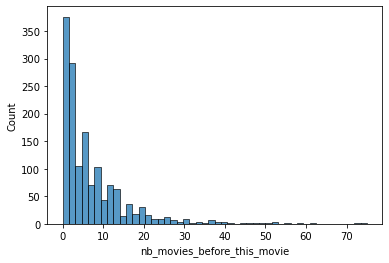

In [60]:
sns.histplot(data=df_final[df_final['is_revealed'] == 1], x='nb_movies_before_this_movie')

<AxesSubplot:>

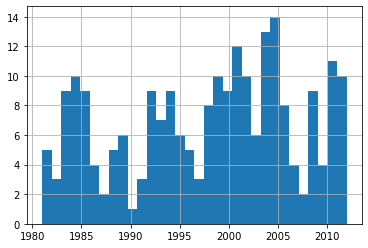

In [62]:
df_final.loc[(df_final['is_revealed'] == 1) & (df_final['nb_movies_before_this_movie'] == 0)]['m_release_year'].hist(
    bins=32)

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_final, x='m_release_year', y='cast_max', hue='is_revealed')
plt.xticks(rotation=90);

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_final, x='m_release_year', y='cast_prop_famous_actors', hue='is_revealed')
plt.xticks(rotation=90);

In [63]:
nb_rows = df_final['is_revealed'].count()
nb_is_revealed = df_final['is_revealed'].sum()
weights = df_final['is_revealed'].apply(
    lambda x: 1 - nb_is_revealed / nb_rows if x else nb_is_revealed / nb_rows).to_list()
df_sampled = df_final.sample(n=4000, replace=True, weights=weights, random_state=1)

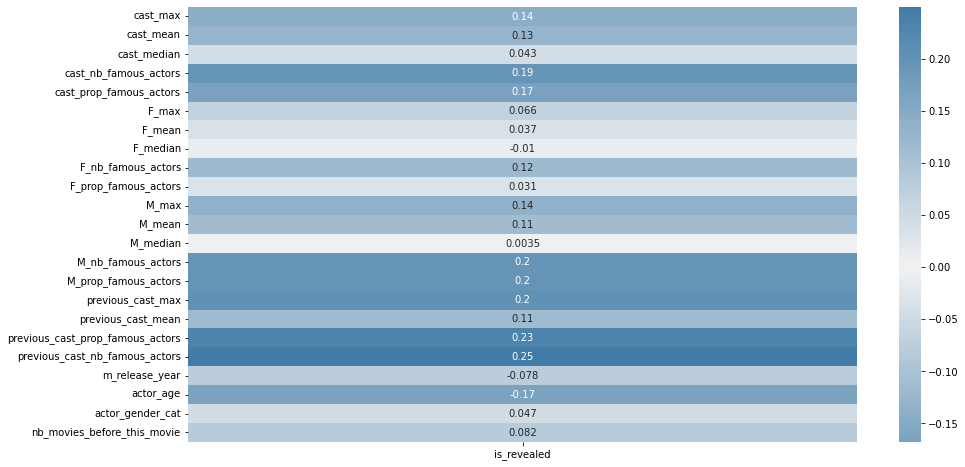

In [64]:
columns = list_columns
dataset = df_sampled[columns].fillna(0)

# Heatmap of the correlation between the attributes and the output 'is_revealed'
corr = dataset.corr()
corr.drop(corr.tail(1).index, inplace=True)
#mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240, 240, as_cmap=True)
sns.heatmap(data=corr[['is_revealed']], cmap=cmap, center=0, annot=True)
plt.show()

In [65]:
revealed_ = df_final[df_final['is_revealed'] == 1]
not_revealed_ = df_final[df_final['is_revealed'] == 0]
ttest_ind(revealed_['cast_prop_famous_actors'], not_revealed_['cast_prop_famous_actors'])

Ttest_indResult(statistic=13.064311602073081, pvalue=5.7964119862139987e-39)

In [66]:
ttest_ind(revealed_['cast_max'], not_revealed_['cast_max'])

Ttest_indResult(statistic=12.648695698552457, pvalue=1.237668834207513e-36)

In [67]:
ttest_ind(revealed_['cast_nb_famous_actors'], not_revealed_['cast_nb_famous_actors'])

Ttest_indResult(statistic=15.722276989530029, pvalue=1.3005699255135099e-55)

## 4.3 Prediction

In [68]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

Accuracy on the training data: 68.79%


In [69]:
# Predict the binary output with a cross validation
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       597
           1       0.67      0.65      0.66       603

    accuracy                           0.66      1200
   macro avg       0.66      0.66      0.66      1200
weighted avg       0.66      0.66      0.66      1200



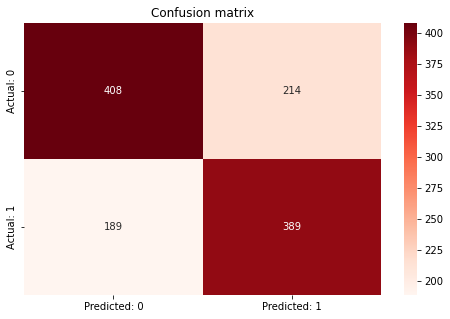

In [70]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion matrix")
plt.show()

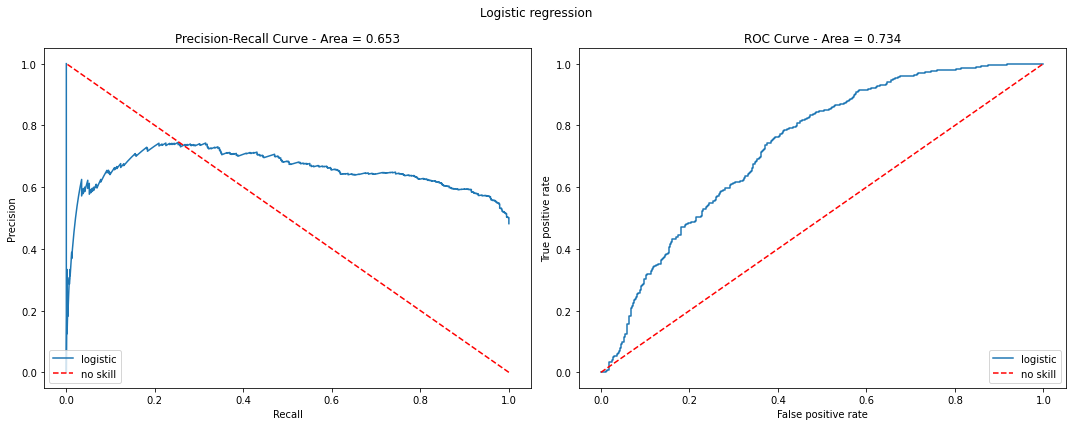

In [71]:
# Predict the probabilities with a cross validation
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1], 'r--', label='no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc='lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1], 'r--', label='no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc='lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [ ]:
columns_names = []

In [94]:
linear_regression_col_names = {
    'cast_max': 'Score of the most famous actor in revelation movie',
    'cast_mean': 'Average score of the casting of the revelation movie',
    'cast_median': 'Median score of the casting of the revelation movie',
    'cast_nb_famous_actors': 'Number of famous actors in revelation movie',
    'cast_prop_famous_actors': 'Ratio of famous actors in revelation movie',
    'F_max': 'Score of the most famous female actress in revelation movie',
    'F_mean': 'Average score of the female casting of the revelation movie',
    'F_median': 'Median score of the female casting of the revelation movie',
    'F_nb_famous_actors': 'Number of famous female actress in revelation movie',
    'F_prop_famous_actors': 'Ratio of famous female actresses in revelation movie',
    'M_max': 'Score of the most famous male actor in revelation movie',
    'M_mean': 'Average score of the male casting of the revelation movie',
    'M_median': 'Median score of the male casting of the revelation movie',
    'M_nb_famous_actors': 'Number of famous male actor in revelation movie',
    'M_prop_famous_actors': 'Ratio of famous male actors in revelation movie',
    'previous_cast_max': 'Score of the most famous actor the actor has played with in the past three years',
    'previous_cast_mean': 'Average score of all actors the actor has played with in the past three years',
    'previous_cast_prop_famous_actors': 'Average ratio of famous actors among each movie of the actor has played with in the past three years',
    'previous_cast_nb_famous_actors': 'Total number of famous actors the actor has played with in the past three years',
    'm_release_year': 'Movie release year',
    'actor_age': 'Actor age',
    'actor_gender_cat': 'Female gender',
    'nb_movies_before_this_movie': 'Number of movies the actor has already starred in'
}


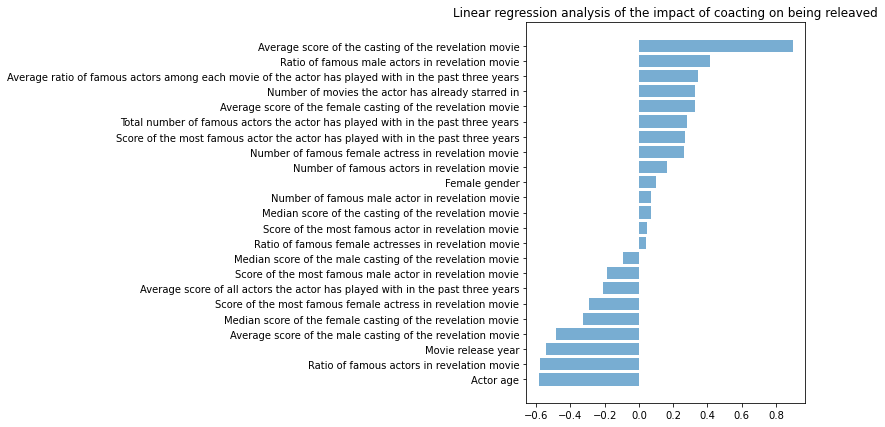

In [95]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns[:-1], clf.coef_[0]):
    tmp.append({"name": linear_regression_col_names[name], "value": value})

features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5, 7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.title('Linear regression analysis of the impact of coacting on being revealed')
plt.show()

In [77]:
regression_columns = dict()
for name, value in zip(dataset.columns[:-1], clf.coef_[0]):
    regression_columns.update({name: value})

In [89]:
regression_columns_operation = 'regression_columns_operation.csv'
with open(regression_columns_operation, 'w') as f:
    writer = csv.writer(f)
    for key, val in regression_columns.items():
        row = [key, val]
        # write a row to the csv file
        writer.writerow(row)

In [ ]:
def retrieve_movie_features(row, arr, gender_arr):
    type_f, function = row.split('_')
    values = list(arr)
    if type_f == 'F' or type_f == 'M':
        values = []
        for x, g in zip(arr, gender_arr):
            if g == type_f:
                values.append(x)
    if function == 'max':
        return max(values)
    if function == 'min':
        return min(values)
    if function == 'mean':
        return np.mean(values)
    if function == 'median':
        return np.median(values)
    if function == 'nb_famous_actors' or function == 'nb_actors_already_played':
        return np.count_nonzero(values)
    if function == 'prop_famous_actors' or function == 'prop_nb_movies':
        if type_f == 'F' or type_f == 'M':
            try:
                return (np.count_nonzero(values)) / np.count_nonzero(values)
            except:
                return 0
        else:
            return (np.count_nonzero(values)) / float(len(values))

# 5. Movie revelation prediction

## 5.1 Grouping movies by actors

In [ ]:
df_movie_revelation = df_final.groupby('wikipedia_m_ID')['is_revealed'].sum().copy().reset_index()
df_movie_revelation.rename({'is_revealed': 'has_revelation'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

In [ ]:
df_movie_revelation['has_revelation'].value_counts()

In [ ]:
df_chars_revelation = df_final.merge(df_movie_revelation, on='wikipedia_m_ID', how='left').copy().sort_values(
    ['wikipedia_m_ID', 'is_revealed'], ascending=False)

In [ ]:
df_revelation = df_chars_revelation.drop_duplicates(subset=['wikipedia_m_ID', 'has_revelation'], keep='first')

In [ ]:
df_revelation = df_revelation[df_revelation['cast_nb_famous_actors'] > 0].copy()

In [ ]:
df_revelation.groupby('has_revelation').mean()

In [ ]:
sns.boxplot(data=df_revelation, x='has_revelation', y='cast_prop_famous_actors')

In [ ]:
df_revelation.groupby('has_revelation')['M_prop_famous_actors'].mean()

In [ ]:
df_revelation.groupby('has_revelation')['F_prop_famous_actors'].mean()

In [ ]:
list_columns = ['cast_max',
                'cast_nb_famous_actors',
                'cast_prop_famous_actors',
                'previous_cast_max',
                'previous_cast_mean',
                'previous_cast_prop_famous_actors',
                'previous_cast_nb_famous_actors',
                'm_release_year']

In [ ]:
nb_rows = df_revelation['has_revelation'].count()
nb_is_revealed = df_revelation['has_revelation'].sum()
weights = df_revelation['has_revelation'].apply(
    lambda x: 1 - nb_is_revealed / nb_rows if x else nb_is_revealed / nb_rows).to_list()
df_sampled_movie_rev = df_revelation.sample(n=4000, replace=True, weights=weights, random_state=1)

columns = list_columns + ['wikipedia_m_ID', 'actor_name', 'has_revelation']
dataset = df_sampled_movie_rev[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean().fillna(0)

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240, 240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [ ]:
X = dataset.drop('has_revelation', axis=1)
y = dataset['has_revelation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=0.5, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validation
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion matrix")
plt.show()

In [ ]:
# Predict the probabilities with a cross validation
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1], 'r--', label='no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc='lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1], 'r--', label='no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc='lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [ ]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})

features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5, 7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 6. Stay in the loop

## 6.1 Load the yearly numbers dataset

In [ ]:
SCORE_YEARLY_PATH = os.path.join(DATA_PATH, 'numbers_yearly.tsv')
df_numbers_yearly = pd.read_csv(SCORE_YEARLY_PATH, sep="\t")
df_numbers_yearly['m_release_date'] = pd.to_datetime(df_chars['m_release_date'], errors='coerce')
df_numbers_yearly.head(2)

In [ ]:
df_numbers_yearly.head(2)

In [ ]:
columns = df_numbers_yearly.columns[1:]

In [ ]:
df_loop = df_chars_merged.loc[
    (df_chars_merged['already_revealed'] == 1) & (df_chars_merged['nb_years_acting'] >= 1)].sort_values(
    ['actor_name', 'm_release_date']).drop_duplicates(['actor_name'], keep='first').copy()
df_loop.drop(columns, axis=1, inplace=True)
df_loop = df_loop.merge(df_numbers_yearly, on='actor_name', how='left').copy()
df_loop.dropna(subset=['actor_gender'], inplace=True)
df_loop.head()

In [ ]:
df_loop['actor_gender'].value_counts()

In [ ]:
def get_score_year(row):
    release_year = row['m_release_date'].year
    return int(row['{}'.format(release_year)] > 0)

In [ ]:
df_loop['still_ranked'] = df_loop.apply(lambda row: get_score_year(row), axis=1)

In [ ]:
df_loop['is_main_actor'] = (df_loop['score_max'] == df_loop['min_year_score']).astype(int)

In [ ]:
df_loop['is_main_actor'].sum()

In [ ]:
df_loop['still_ranked'].sum()

In [ ]:
df_loop[df_loop['still_ranked'] == 1]['is_main_actor'].sum()

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 0)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 1) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
df_loop.loc[(df_loop['is_main_actor'] == 0) & (df_loop['still_ranked'] == 1)].shape

In [ ]:
#df_loop.drop_duplicates('wikipedia_m_ID', keep='first', inplace=True)

In [ ]:
df_loop['wikipedia_m_ID'].nunique()

In [ ]:
df_loop.groupby('still_ranked')[list_columns + ['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender'] == 'M'].groupby('still_ranked')[list_columns + ['is_main_actor']].mean()

In [ ]:
df_loop[df_loop['actor_gender'] == 'F'].groupby('still_ranked')[list_columns + ['is_main_actor']].mean()

In [ ]:
sns.histplot(data=df_loop, x='actor_gender', hue='still_ranked', cumulative=False, multiple='fill', stat='proportion')
plt.grid();

In [ ]:
sns.boxplot(data=df_loop, x='actor_gender', y='score_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop, x='actor_gender', y='F_max', hue='still_ranked')

In [ ]:
sns.boxplot(data=df_loop, x='actor_gender', y='M_max', hue='still_ranked')

In [ ]:
df_tmp = df_loop.dropna()
ttest_ind(df_tmp[df_tmp['still_ranked'] == 1]['M_max'], df_tmp[df_tmp['still_ranked'] == 0]['M_max'])

In [ ]:
ttest_ind(df_tmp[df_tmp['still_ranked'] == 1]['F_max'], df_tmp[df_tmp['still_ranked'] == 0]['F_max'])